In [1]:
from matplotlib import pyplot as plt
import cv2
import pytesseract

In [2]:
def show_img_notebook(fname_or_image, gray = False):
    img = cv2.imread(fname) if isinstance(fname_or_image, str) else fname_or_image
    if gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    plt.title(fname)
    plt.show()

    
def parse_image(fname_or_image):
    img = cv2.imread(fname) if isinstance(fname_or_image, str) else fname_or_image
    custom_config = r'--oem 3 --psm 6'
    s = pytesseract.image_to_string(img, config=custom_config)
    print(s)

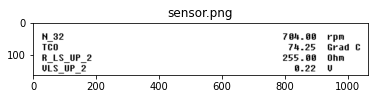

N_32 764.00 rpm
Tco 74.25 Grad C
R_LS_UP 2 255.60 Ohm
ULS_UP_2 8.22 U



In [3]:
fname = 'sensor.png'
show_img_notebook(fname)
parse_image(fname)

# confuses slashed 0 with 6 and 8
# known problem https://stackoverflow.com/questions/53090447/tesseract-ocr-confuses-slashed-0-as-8

In [4]:
# create example of slashed 0 and manually edit "0fixed.png" with clean 0
img = cv2.imread('sensor.png')
print(img.shape)  # Print image shape
cropped_image = img[31:55, 812:829]
#cv2.imshow("cropped", cropped_image)
_ = cv2.imwrite('0slashed_example.png', cropped_image)

(164, 1064, 3)


In [13]:
THRESHOLD = 0.9

def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def close_enough(img, p1, p2):  # check if (x,y) is close enough to (xx,yy) to fit in img
    h, w = img.shape
    x1, y1, _ = p1
    x2, y2, _ = p2
    if abs(x1 - x2) < w/2 and abs(y1 - y2) < h/2:
        return True
    return False

def fix_zero(fname):
    """ correlation hack, works for known size of chars """
    img = get_grayscale(cv2.imread(fname))
    t = get_grayscale(cv2.imread('0slashed_example.png'))
    f = get_grayscale(cv2.imread('0fixed.png'))
    matches = cv2.matchTemplate(img, t, cv2.TM_CCOEFF_NORMED)
    sorted_matches = sorted([(x,y,matches[y][x]) for x in range(len(matches[0])) for y in range(len(matches))], key=lambda v: v[2], reverse=True)
    sorted_matches = list(filter(lambda v: v[2]>THRESHOLD, sorted_matches))
    while sorted_matches:
        x, y, _ = sorted_matches[-1]
        h, w = f.shape
        img[y:y+h, x:x+w] = f
        print('replace', x, y)
        sorted_matches = [match for match in sorted_matches if not close_enough(t, (x, y, 0), match)]
    return img

replace 865 97
replace 883 97
replace 865 31
replace 830 131
replace 883 31
replace 812 31


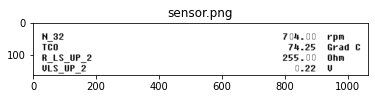

N_32 704.00 rpm
Tco 74.25 Grad C
R_LS_UP 2 255.00 Ohm
ULS_UP_2 0.22 U



In [14]:
img = fix_zero('sensor.png')
show_img_notebook(img)
parse_image(img)

# fixed!

replace 861 21
replace 861 88
replace 861 121
replace 826 121
replace 879 21
replace 879 88


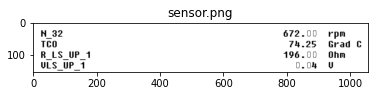

N32 672.00 rpm
Tco 74.25 Grad C
R_LS_UP_1 196.00 Ohm
ULS_UP_1 0.04 vu



In [15]:
img = fix_zero('sensor2.png')
show_img_notebook(img)
parse_image(img)

# fixed!